# Time Series Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

In [4]:
data=pd.read_csv("TESLA.CSV")

In [5]:
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-05-21,39.551998,41.480000,39.208000,41.015999,90019500,0,0.0
1,2019-05-22,39.820000,40.787998,38.355999,38.546001,93426000,0,0.0
2,2019-05-23,38.868000,39.894001,37.243999,39.098000,132735500,0,0.0
3,2019-05-24,39.966000,39.995998,37.750000,38.125999,70683000,0,0.0
4,2019-05-28,38.240002,39.000000,37.570000,37.740002,51564500,0,0.0


In [6]:
stock_data=data[["Date","Close"]]

In [7]:
stock_data.head(7)

,Date,Close
0,2019-05-21,41.015999
1,2019-05-22,38.546001
2,2019-05-23,39.098000
3,2019-05-24,38.125999
4,2019-05-28,37.740002
5,2019-05-29,37.972000
6,2019-05-30,37.644001


In [8]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    758 non-null    object 
 1   Close   758 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [9]:
stock_data["Date"] = pd.to_datetime(stock_data["Date"])

In [10]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    758 non-null    datetime64[ns]
 1   Close   758 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [11]:
stock_data.head(2)

,Date,Close
0,2019-05-21,41.015999
1,2019-05-22,38.546001


In [12]:
stock_data=stock_data.set_index("Date")

In [13]:
stock_data

,Close
Date,
2019-05-21,41.015999
2019-05-22,38.546001
2019-05-23,39.098000
2019-05-24,38.125999
2019-05-28,37.740002
...,...
2022-05-16,724.369995
2022-05-17,761.609985
2022-05-18,709.809998


In [14]:
stock_data.head()

,Close
Date,
2019-05-21,41.015999
2019-05-22,38.546001
2019-05-23,39.098000
2019-05-24,38.125999
2019-05-28,37.740002


## Exploratory Data Analysis

In [15]:
stock_data.describe()

,Close
count,758.000000
mean,485.531513
std,353.160353
min,35.793999
25%,112.323500
50%,488.125000
75%,762.142502
max,1229.910034


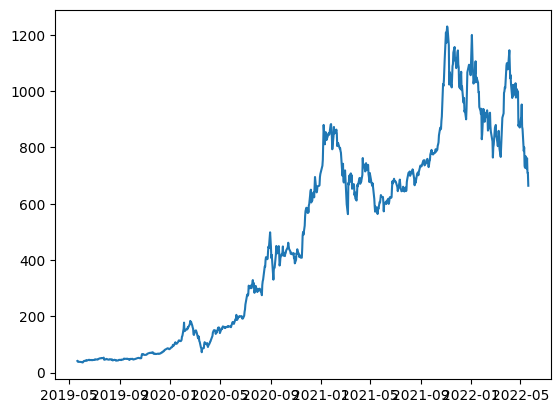

In [16]:
plt.plot(stock_data.Close)

(array([228.,  57.,  38.,  59.,  50., 127.,  81.,  44.,  59.,  15.]),
 array([  35.79399872,  155.20560226,  274.61720581,  394.02880936,
         513.4404129 ,  632.85201645,  752.26362   ,  871.67522354,
         991.08682709, 1110.49843063, 1229.91003418]),
 <BarContainer object of 10 artists>)

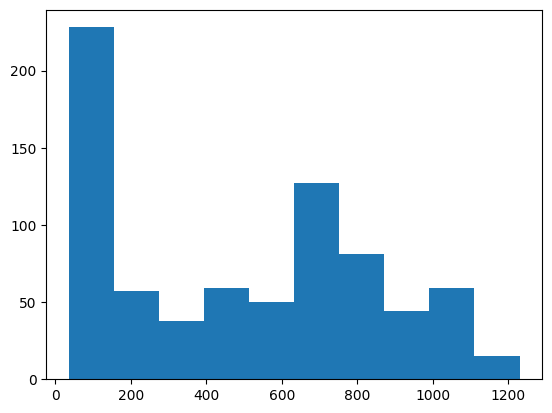

In [17]:
plt.hist(stock_data.Close)

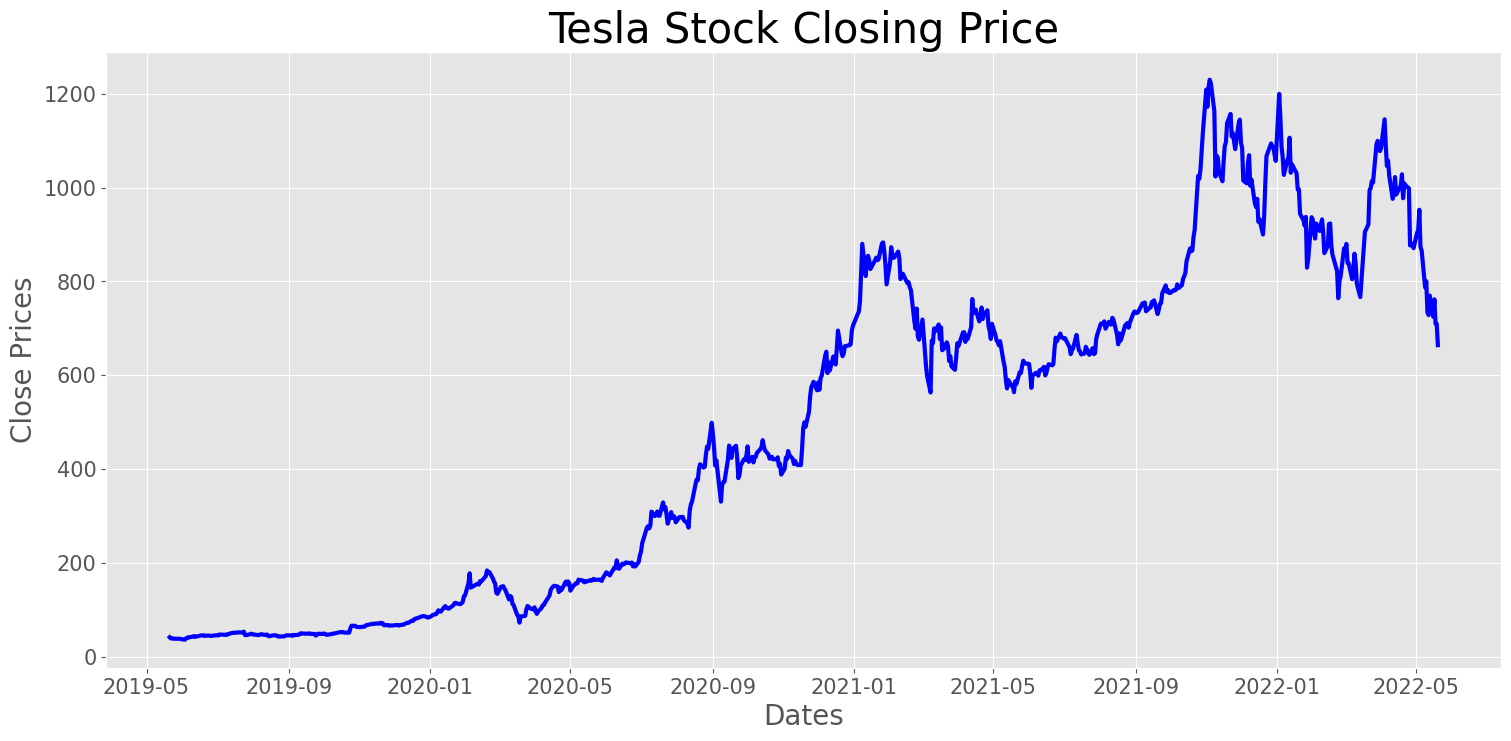

In [18]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Close Prices', fontsize = 20)
plt.yticks(fontsize = 15)
plt.plot(stock_data['Close'], linewidth = 3, color = 'blue')
plt.title('Tesla Stock Closing Price', fontsize = 30)
plt.show()

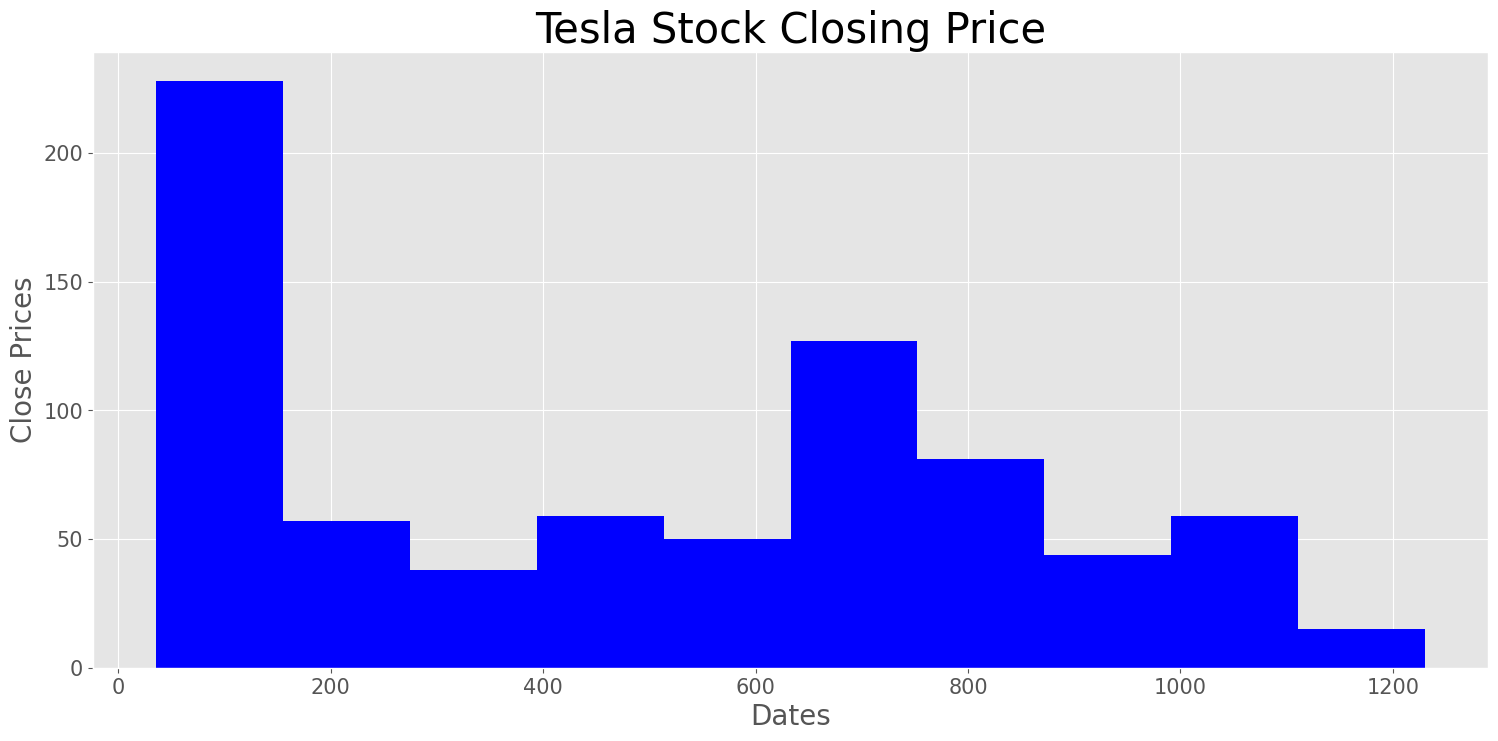

In [19]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Close Prices', fontsize = 20)
plt.yticks(fontsize = 15)
plt.hist(stock_data['Close'], linewidth = 3, color = 'blue')
plt.title('Tesla Stock Closing Price', fontsize = 30)
plt.show()

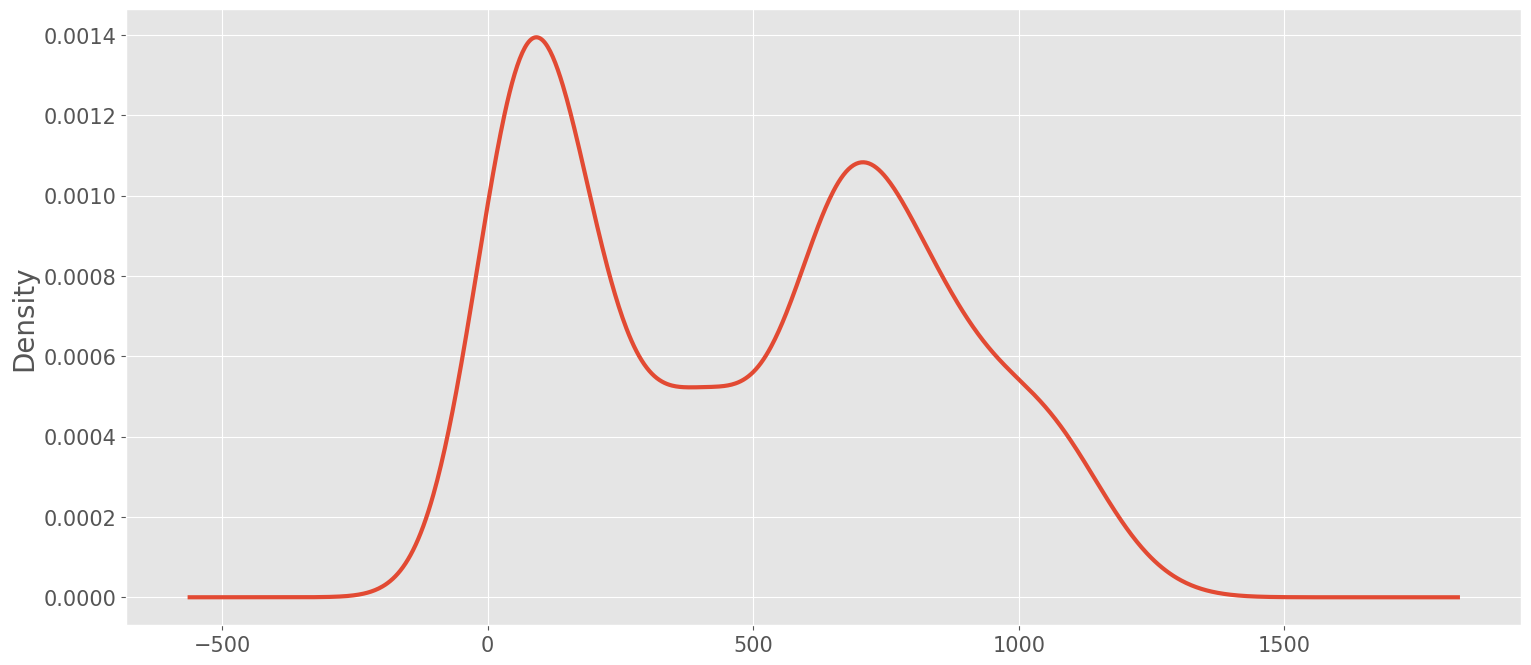

In [20]:
df_close = stock_data['Close']
df_close.plot(kind='kde',figsize = (18,8), linewidth= 3)
plt.xticks(fontsize = 15)
plt.grid("both")
plt.ylabel('Density', fontsize = 20)
plt.yticks(fontsize = 15)
plt.show()

In [21]:
rolmean=stock_data["Close"].rolling(48).mean()

In [22]:
rolstd=stock_data["Close"].rolling(48).std()

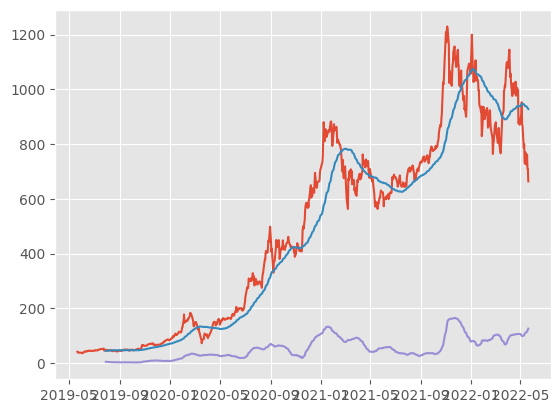

In [23]:
plt.plot(stock_data.Close)
plt.plot(rolmean)
plt.plot(rolstd)

In [24]:
adft=adfuller(stock_data["Close"])

In [25]:
pd.Series(adft[0:4],index=["test stats","p-value","lag","data points"])

,0
test stats,-1.363009
p-value,0.599876
lag,9.000000
data points,748.000000


In [26]:
#Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(48).mean() # rolling mean
    rolstd = timeseries.rolling(48).std() # rolling standard deviation
    # Plot rolling statistics:
    plt.figure(figsize = (18,8))
    plt.grid('both')
    plt.plot(timeseries, color='blue',label='Original', linewidth = 3)
    plt.plot(rolmean, color='red', label='Rolling Mean',linewidth = 3)
    plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth = 4)
    plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

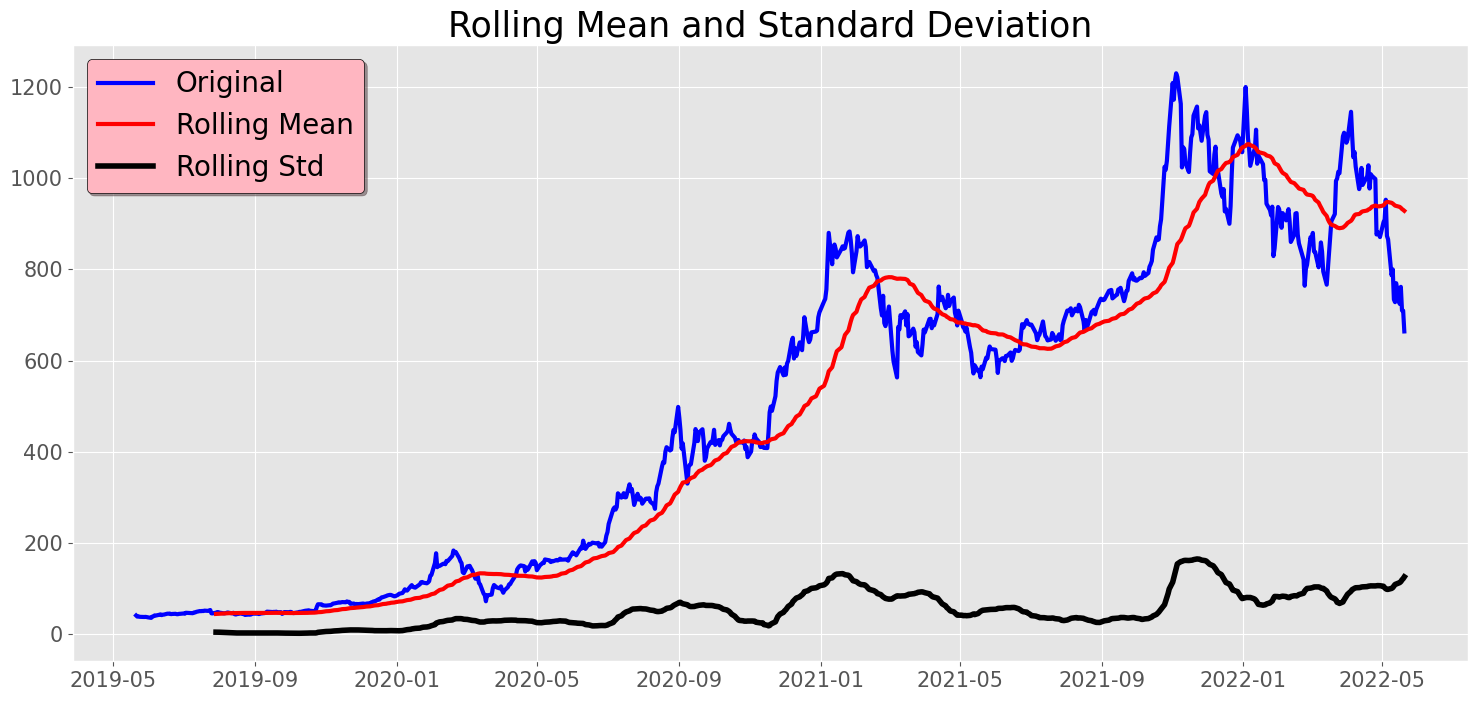

Results of dickey fuller test
Test Statistics                 -1.363009
p-value                          0.599876
No. of lags used                 9.000000
Number of observations used    748.000000
critical value (1%)             -3.439123
critical value (5%)             -2.865412
critical value (10%)            -2.568832
dtype: float64


In [27]:
test_stationarity(stock_data.Close)

In [28]:
result = seasonal_decompose(stock_data[["Close"]],period=12,model="multiplicative")

In [29]:
result.seasonal

,seasonal
Date,
2019-05-21,0.998285
2019-05-22,1.007787
2019-05-23,0.997675
2019-05-24,0.992710
2019-05-28,0.988533
...,...
2022-05-16,1.005393
2022-05-17,1.007126
2022-05-18,1.003538


<Figure size 2000x1000 with 0 Axes>

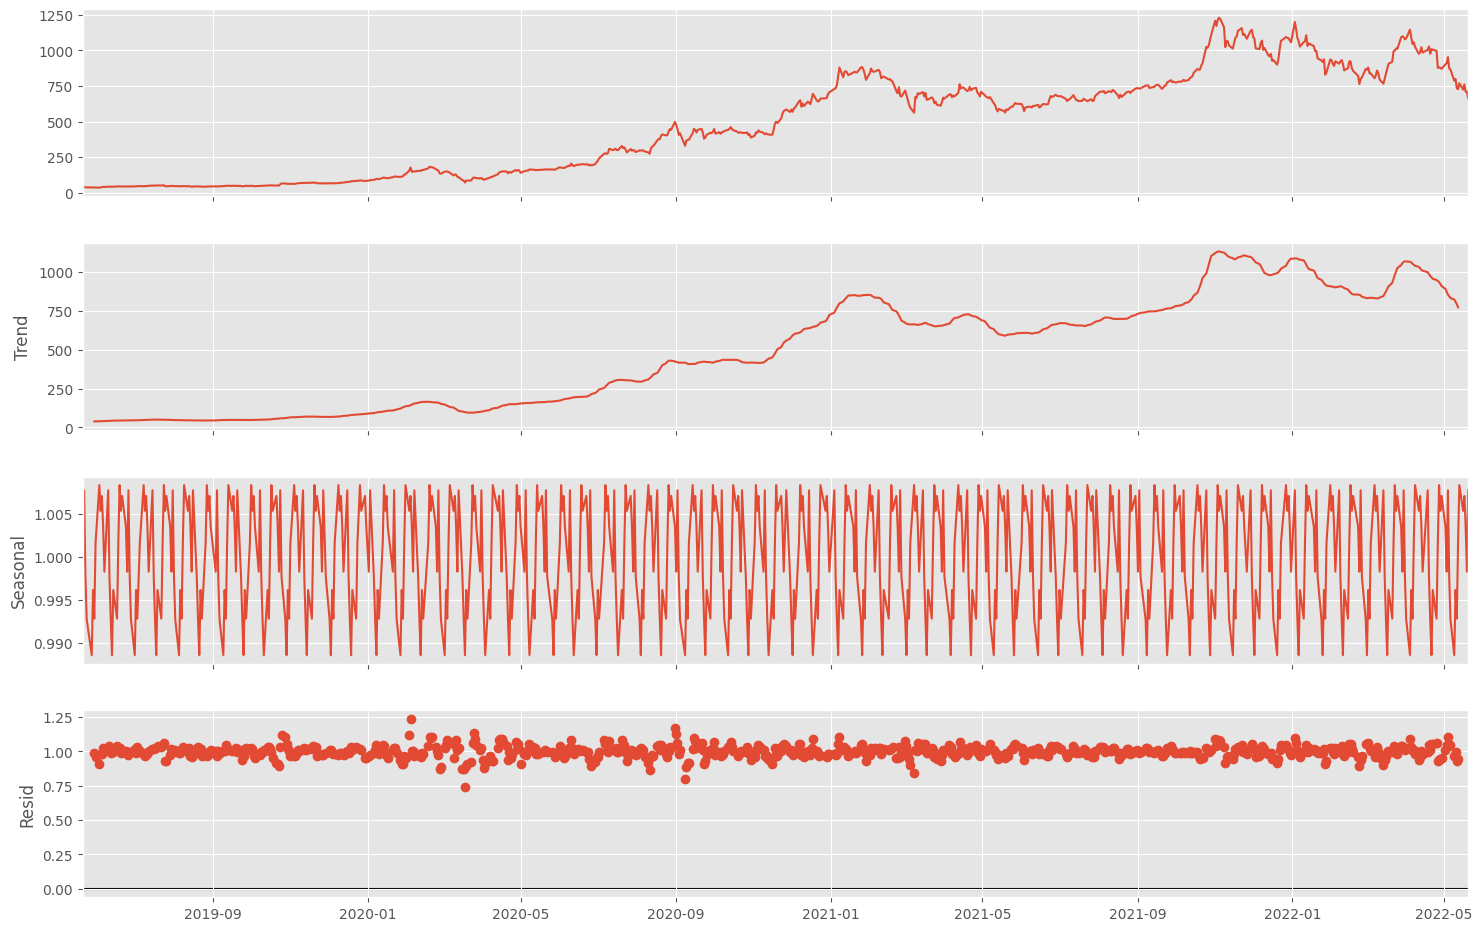

In [30]:
fig=plt.figure(figsize=(20,10))
fig=result.plot()
fig.set_size_inches(17,10)

<Axes: ylabel='Close'>

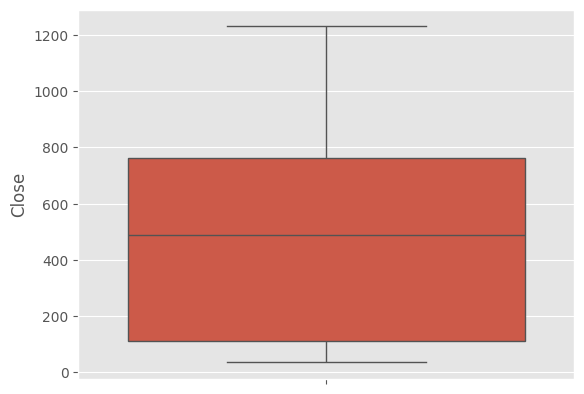

In [31]:
sns.boxplot(stock_data.Close)

## Model Building

In [32]:
train_data, test_data = train_test_split(stock_data['Close'], test_size=0.2, shuffle=False)

In [33]:
history=[x for x in train_data]

In [34]:
model=ARIMA(history,order=(1,1,1))

In [35]:
model=model.fit()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  606
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2553.555
Date:                Sun, 20 Oct 2024   AIC                           5113.111
Time:                        07:41:36   BIC                           5126.326
Sample:                             0   HQIC                          5118.253
                                - 606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0393      0.366      0.107      0.914      -0.678       0.756
ma.L1         -0.1090      0.357     -0.305      0.760      -0.809       0.592
sigma2       271.4737      7.746     35.047      0.000     256.292     286.656
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1042.08
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              21.40   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model.forecast()[0]

810.5972492984631

In [38]:
test_data[0]

818.3200073242188

In [39]:
mean_squared_error([test_data[0]],model.forecast())

59.64099152437312

In [40]:
np.sqrt(mean_squared_error([test_data[0]],model.forecast()))

7.722758025755638

In [41]:
def train_arima_model(X, y, arima_order):
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(y[t])
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

In [42]:
def evaluate_models(train_data, test_data, p_values, d_values, q_values):
    """
    Evaluates ARIMA models with different p, d, and q values and prints the best model's RMSE.

    Args:
        train_data: The training dataset.
        test_data: The testing dataset.
        p_values: A range of values for the ARIMA model's p parameter.
        d_values: A range of values for the ARIMA model's d parameter.
        q_values: A range of values for the ARIMA model's q parameter.
    """
    best_score, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = train_arima_model(train_data, test_data, order)
                    if rmse < best_score:
                        best_score, best_order = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(f"Error with ARIMA{order}: {e}")
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_order, best_score))

In [43]:
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(train_data, test_data, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=553.026
ARIMA(0, 0, 1) RMSE=290.164
ARIMA(0, 0, 2) RMSE=195.563
ARIMA(0, 1, 0) RMSE=42.391
ARIMA(0, 1, 1) RMSE=42.509
ARIMA(0, 1, 2) RMSE=42.641
ARIMA(0, 2, 0) RMSE=60.405
ARIMA(0, 2, 1) RMSE=42.633
ARIMA(0, 2, 2) RMSE=42.854
ARIMA(1, 0, 0) RMSE=42.369
ARIMA(1, 0, 1) RMSE=42.476
ARIMA(1, 0, 2) RMSE=42.613
ARIMA(1, 1, 0) RMSE=42.510
ARIMA(1, 1, 1) RMSE=42.589
ARIMA(1, 1, 2) RMSE=43.017
ARIMA(1, 2, 0) RMSE=51.819
ARIMA(1, 2, 1) RMSE=42.839
ARIMA(1, 2, 2) RMSE=42.867
ARIMA(2, 0, 0) RMSE=42.481
ARIMA(2, 0, 1) RMSE=42.529
ARIMA(2, 0, 2) RMSE=42.644
ARIMA(2, 1, 0) RMSE=42.652
ARIMA(2, 1, 1) RMSE=42.940
ARIMA(2, 1, 2) RMSE=42.730
ARIMA(2, 2, 0) RMSE=49.401
ARIMA(2, 2, 1) RMSE=43.009
ARIMA(2, 2, 2) RMSE=42.966
Best ARIMA(1, 0, 0) RMSE=42.369


In [44]:
history = [x for x in train_data]

In [45]:
predictions = list()
conf_list = list()

In [46]:
for t in range(len(test_data)):
    model = ARIMA(history,order=(2,0,0))
    model_fit = model.fit()
    fc = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    history.append(test_data[t])

In [47]:
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_data, predictions)))

RMSE of ARIMA Model: 42.480528390359005


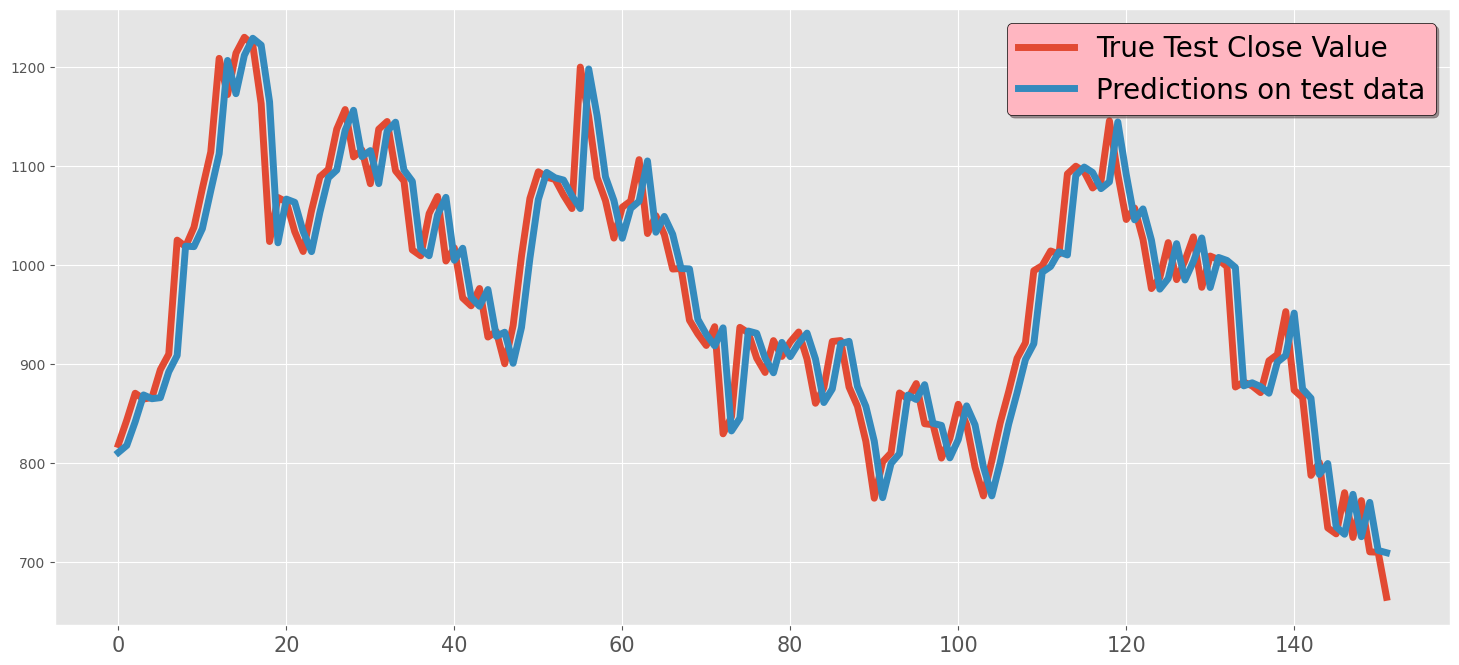

In [48]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'True Test Close Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions on test data', linewidth = 5)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

In [49]:
fc_series = pd.Series(predictions, index=test_data.index)

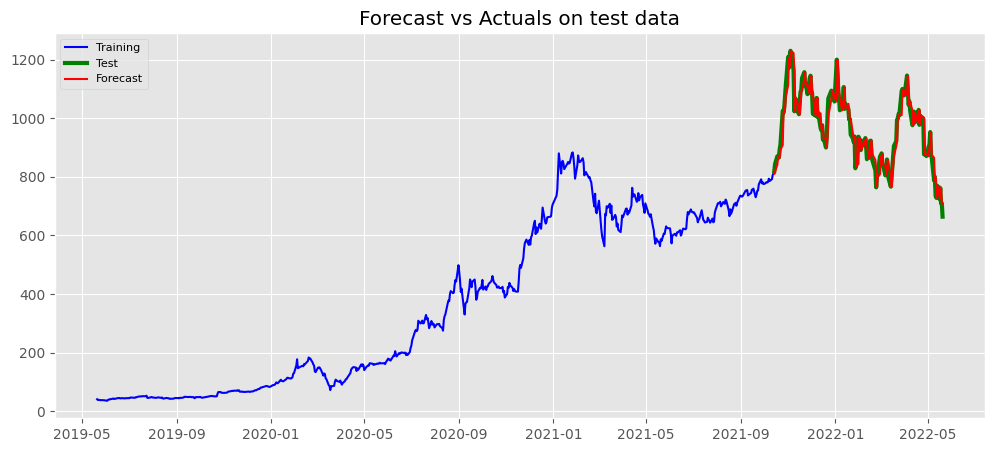

In [50]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training', color = 'blue')
plt.plot(test_data, label='Test', color = 'green', linewidth = 3)
plt.plot(fc_series, label='Forecast', color = 'red')
plt.title('Forecast vs Actuals on test data')
plt.legend(loc='upper left', fontsize=8)
plt.show()

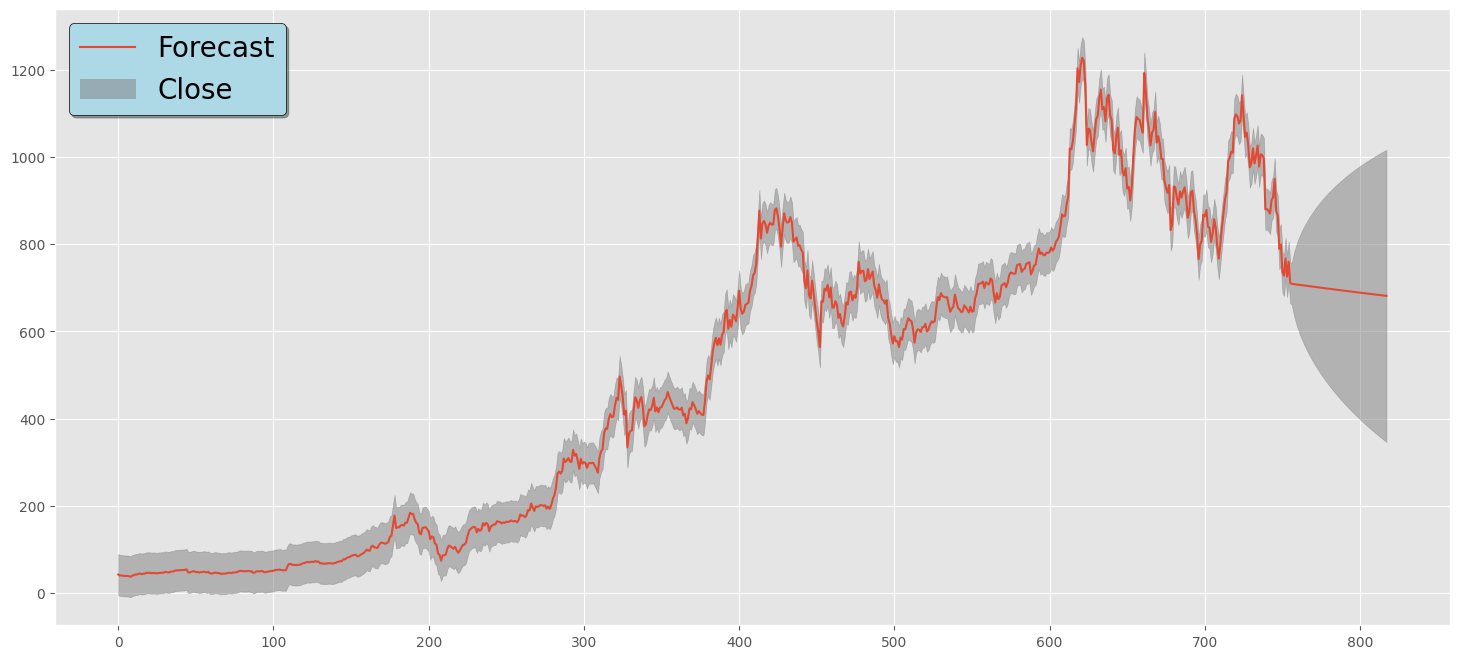

In [51]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(111)
plot_predict(result=model_fit,start=1, end=len(df_close)+60, ax = ax1)
plt.grid("both")
plt.legend(['Forecast','Close','95% confidence interval'],fontsize = 20, shadow=True,facecolor='lightblue',edgecolor = 'k')
plt.show()

In [53]:
history = [x for x in train_data]

In [54]:
predictions = list()
conf_list = list()

In [55]:
for t in range(len(test_data)):
    model = sm.tsa.statespace.SARIMAX(history, order = (0,1,0), seasonal_order = (1,1,1,3))
    model_fit = model.fit()
    fc = model_fit.forecast()
    predictions.append(fc)
    history.append(test_data[t])

In [56]:
print('RMSE of SARIMA Model:', np.sqrt(mean_squared_error(test_data, predictions)))

RMSE of SARIMA Model: 42.68894708921249


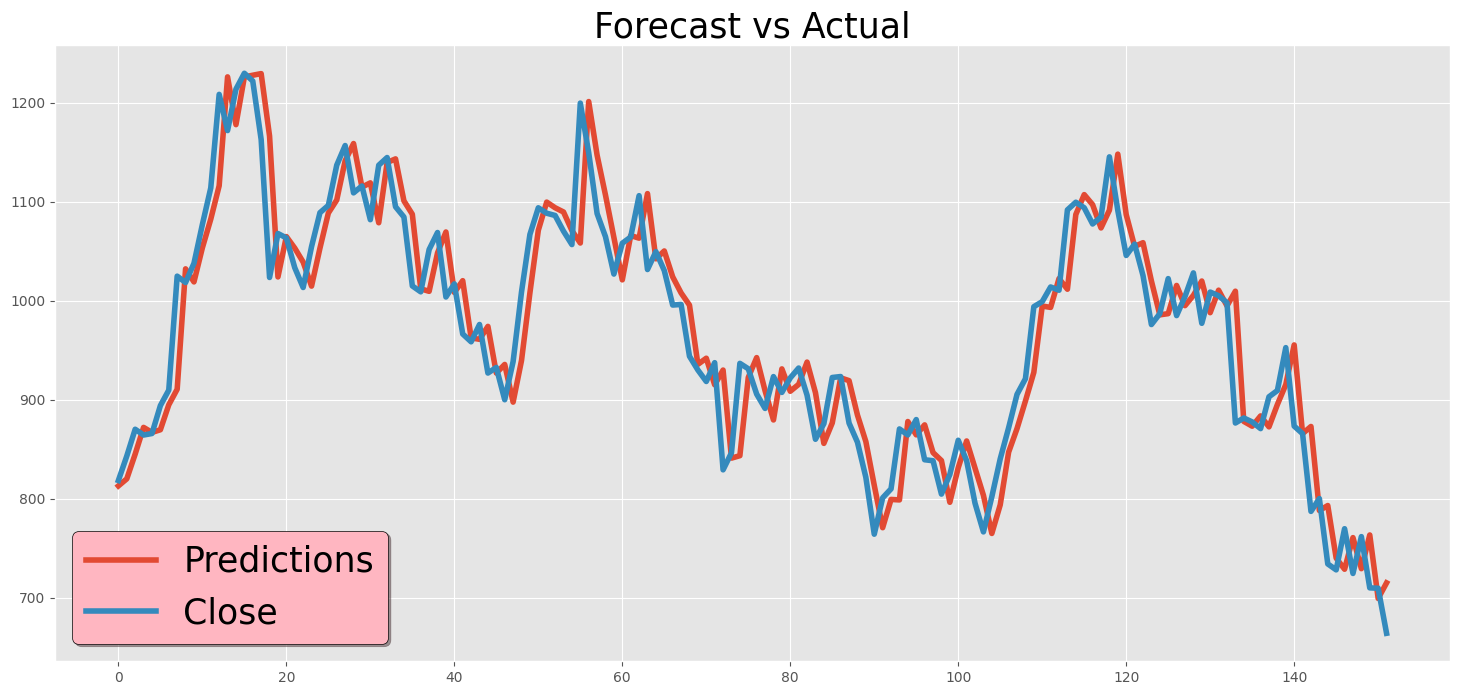

In [57]:
plt.figure(figsize=(18,8))
plt.title('Forecast vs Actual', fontsize = 25)
predicted_values = [p[0] for p in predictions]
plt.plot(range(len(test_data)), predicted_values[:len(test_data)], label = 'Predictions', linewidth = 4)
plt.plot(range(len(test_data)), test_data, label = 'Close', linewidth = 4)
plt.legend(fontsize = 25, shadow=True,facecolor='lightpink',edgecolor = 'k')